In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
from tensorflow import keras
import tensorflow
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from tensorflow.keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from tensorflow.keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from IPython.display import SVG
# from tensorflow.keras.utils.vis_utils import model_to_dot
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import os
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import MaxPool2D
import ssl
import tensorflow as tf
# import matplotlib.pyplot as plt
# ssl._create_default_https_context = ssl._create_unverified_context

In [23]:
dataset_path = os.listdir('datasets/CASIA-PalmprintV1')
folder_name = os.listdir('datasets/CASIA-PalmprintV1')


persons =[]
for person_name in (folder_name):

    folder_path = os.listdir('datasets/CASIA-PalmprintV1' + '/' + person_name)
    for filename in folder_path:
        if filename.endswith(".jpg"):
            persons.append((person_name, str('datasets/CASIA-PalmprintV1' + '/' + person_name) + '/' + filename))



person_df = pd.DataFrame(data=persons, columns=['name','img'])
person_count = person_df['name'].value_counts()

print(len(person_count))

310


In [24]:
im_size = 224
images =[]
labels =[]

path = 'datasets/CASIA-PalmprintV1/'
for i in folder_name:
    print("Reading", i)
    data_path = path + str(i)
    filenames = [i for i in os.listdir(data_path) if i.endswith(".jpg")]
    for file in filenames:
        img = cv2.imread(data_path + '/' + file)
        resize = cv2.resize(img, (224,224))
        images.append(resize)
        labels.append(i)

Reading 0001
Reading 0002
Reading 0003
Reading 0004
Reading 0005
Reading 0006
Reading 0007
Reading 0008
Reading 0009
Reading 0010
Reading 0011
Reading 0012
Reading 0013
Reading 0014
Reading 0015
Reading 0016
Reading 0017
Reading 0018
Reading 0019
Reading 0020
Reading 0021
Reading 0022
Reading 0023
Reading 0024
Reading 0025
Reading 0026
Reading 0027
Reading 0028
Reading 0029
Reading 0030
Reading 0031
Reading 0032
Reading 0033
Reading 0034
Reading 0035
Reading 0036
Reading 0037
Reading 0038
Reading 0039
Reading 0040
Reading 0041
Reading 0042
Reading 0043
Reading 0044
Reading 0045
Reading 0046
Reading 0047
Reading 0048
Reading 0049
Reading 0050
Reading 0051
Reading 0052
Reading 0053
Reading 0054
Reading 0055
Reading 0056
Reading 0057
Reading 0058
Reading 0059
Reading 0060
Reading 0061
Reading 0062
Reading 0063
Reading 0064
Reading 0065
Reading 0066
Reading 0067
Reading 0068
Reading 0069
Reading 0070
Reading 0071
Reading 0072
Reading 0073
Reading 0074
Reading 0075
Reading 0076
Reading 0077

In [25]:
print(len(images), len(labels))

5502 5502


In [26]:
images = np.asarray(images)
print(images.shape)

images = images.astype('float32')/255.0
#print(images.shape)

y = person_df['name'].values
print(y.shape)

y_labelencod = LabelEncoder()
y = y_labelencod.fit_transform(y)


y = y.reshape(-1,1)
onehot = OneHotEncoder(categories='auto')
Y = onehot.fit_transform(y)
print(Y.shape)

images,Y = shuffle(images,Y, random_state=1)

#split trainset=80% testset=20%
train_x,test_x,train_y,test_y = train_test_split(images,Y, test_size=0.2, random_state=0)
train_y=train_y.toarray().astype(np.float32)
test_y=test_y.toarray().astype(np.float32)

(5502, 224, 224, 3)
(5502,)
(5502, 310)


In [42]:
from tensorflow.keras import applications
conv_model = applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in conv_model.layers:
    layer.trainable = False
x = tensorflow.keras.layers.Flatten()(conv_model.output)
x = tensorflow.keras.layers.Dense(4096, activation='relu')(x)
x = tensorflow.keras.layers.Dense(4096, activation='relu')(x)
x= tensorflow.keras.layers.Dropout(0.2)(x)
predictions = tensorflow.keras.layers.Dense(310, activation='softmax')(x)

# creating the full model:
full_model = tensorflow.keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)

full_model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
history = full_model.fit(train_x,train_y, epochs=20, batch_size=64, validation_split=0.1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

KeyboardInterrupt: 

In [8]:
test_loss,test_acc = full_model.evaluate(test_x,test_y)
print("Test Accuray: ",test_acc)
print("Test Loss: ",test_loss)

train_loss,train_acc = full_model.evaluate(train_x,train_y)
print("Train Accuracy:",train_acc)
print("Train loss:", train_loss)

10/10 [==============================] - 6s 346ms/step - loss: 0.4999 - accuracy: 0.9270
Test Accuray:  0.9269841313362122
Test Loss:  0.49992331862449646
40/40 [==============================] - 4s 96ms/step - loss: 0.0195 - accuracy: 0.9960
Train Accuracy: 0.9960286021232605
Train loss: 0.019455820322036743


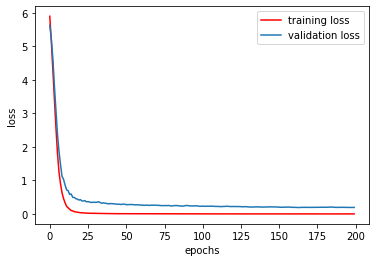

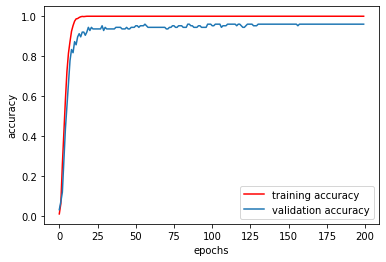

In [9]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()